In [1]:
#LOAD THE DEPENDENCIES
import os
import PIL
import cv2
import logging
import itertools
import scikitplot 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pickle import load
from keras import applications
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from keras.models import Model, Input, load_model
from sklearn.metrics import mean_squared_log_error
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121, preprocess_input
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [3]:
#PREPARE THE INPUT LAYER AND DATA FOR VALIDATION

validation_data_dir = "dataset/validation/"

img_width, img_height = 224, 224
input_shape = (img_width,img_height,3)
model_input = Input(shape=input_shape)
print("Validation folder found!")
print("The Input size is set to ", model_input) 

Validation folder found!
The Input size is set to  Tensor("input_2:0", shape=(?, 224, 224, 3), dtype=float32)


In [9]:
#HYPER-PARAMETERS USED NO NEED TO CHANGE. MAKE SURE IT MATCHES WITH YOUR TRAINED MODEL.

batch_size = 16

epochs = 25

print("Batch Size is set to:", batch_size)
print("Epoch is set to:", epochs)
print()
print("Make sure it matches with your trained model before proceeding to prevent problems")

Batch Size is set to: 16
Epoch is set to: 25

Make sure it matches with your trained model before proceeding to prevent problems


In [16]:
#PREPARE THE VALIDATION DATA GENERATOR
                                
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
         classes=['0_Normal', '1_Covid19', '2_Pneumonia'])

#identify the number of samples
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes
num_classes= len(validation_generator.class_indices)

if validation_generator.class_indices ==3:
    print()
    print("Incorrect number of classes! Please check your folders and data first!")
else:
    print()
    print("Three classes found!")

if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")
    
if nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")    

Found 1841 images belonging to 3 classes.

Three classes found!
Validation samples found!
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [24]:
#LOAD THE TRAINED MODEL USING  THE model_trainer.ipynb

history = load(open('history/fused_densenet_tiny.pkl', 'rb'))
model = load_model('weights/fused_densenet_tiny.h5')
model.name="Fused-DenseNet-Tiny"
model.summary()

if len(model.layers) == 152:
    print("MODEL IS READY!")
elif len(model.layers) != 152:
    print("INCORRECT MODEL!")
    
print("FUSED-DENSENET-TINY MODEL SUCCESSFULLY LOADED!")

Model: "Fused-DenseNet-Tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_2 (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_1_2[0][0]                  
__________________________________________________________________________________________________
zero_padding2d_7_2 (ZeroPadding (None, 230, 230, 3)  0           input_1_2[0][0]                  
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
________________________________________________________________________________

In [25]:
#VISUAL CUSTOMIZER

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for an easier evaluation")

You may change the values if needed for an easier evaluation


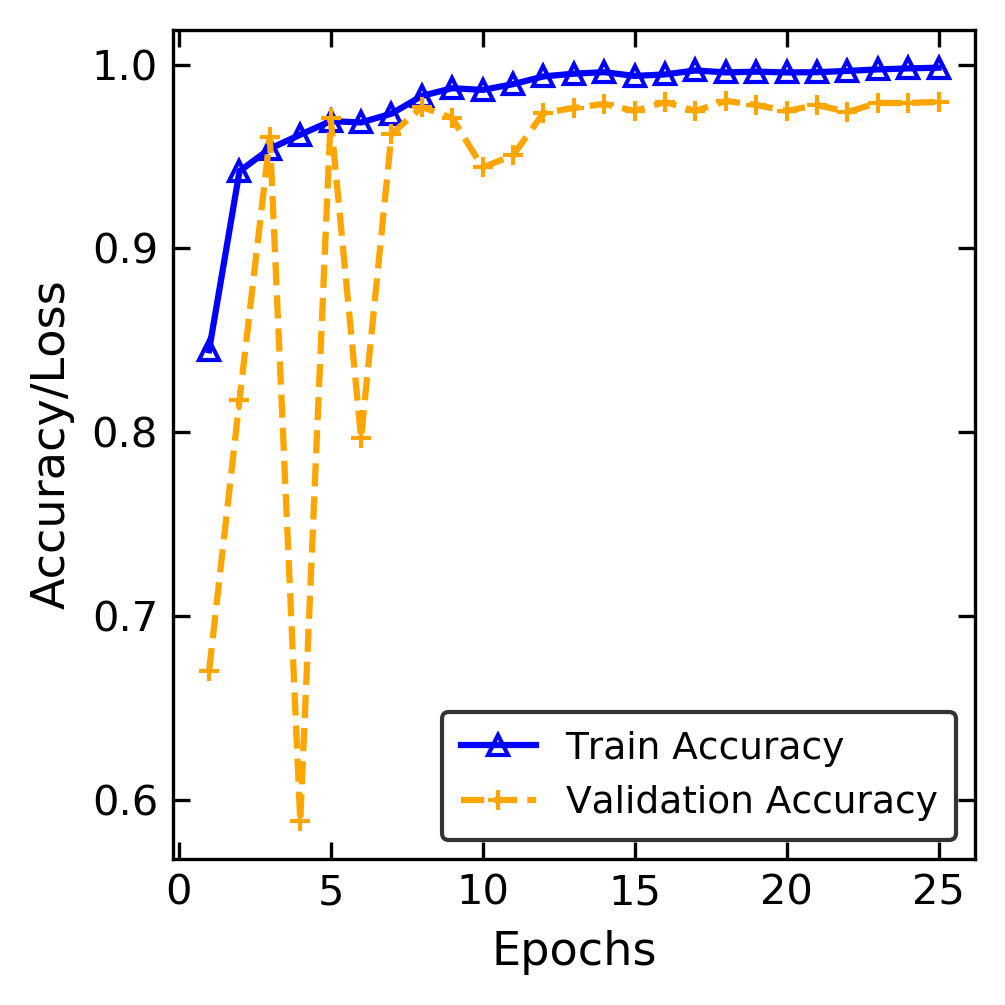

In [26]:
#PRINTS THE ACCURACY GROWTH

N = epochs
plt.style.use("default")
plt.figure(figsize=(1.15*3,1.15*3), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in" ) 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), history.history["acc"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), history.history["val_acc"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Accuracy/Loss", fontsize=3.7*3, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("figures/1-accuracy.jpg", bbox_inches='tight', dpi=600)

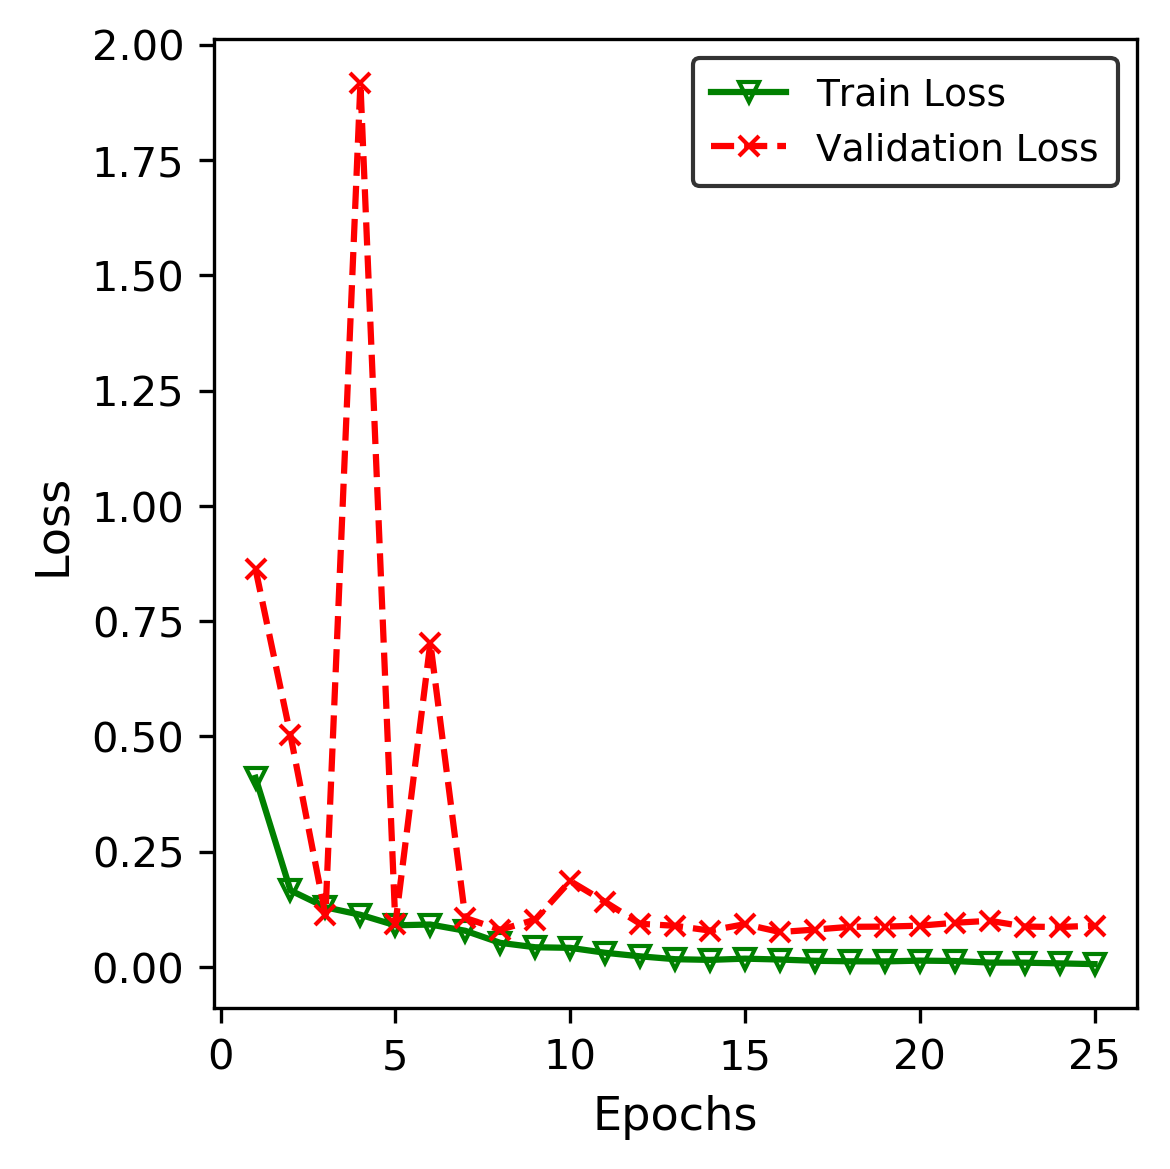

In [27]:
#PRINTS THE DECREASE OF LOSS

N = epochs
plt.style.use("default")
plt.figure(figsize=(4,4), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Loss")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Loss", fontsize=3.7*3, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("figures/2-loss.png")

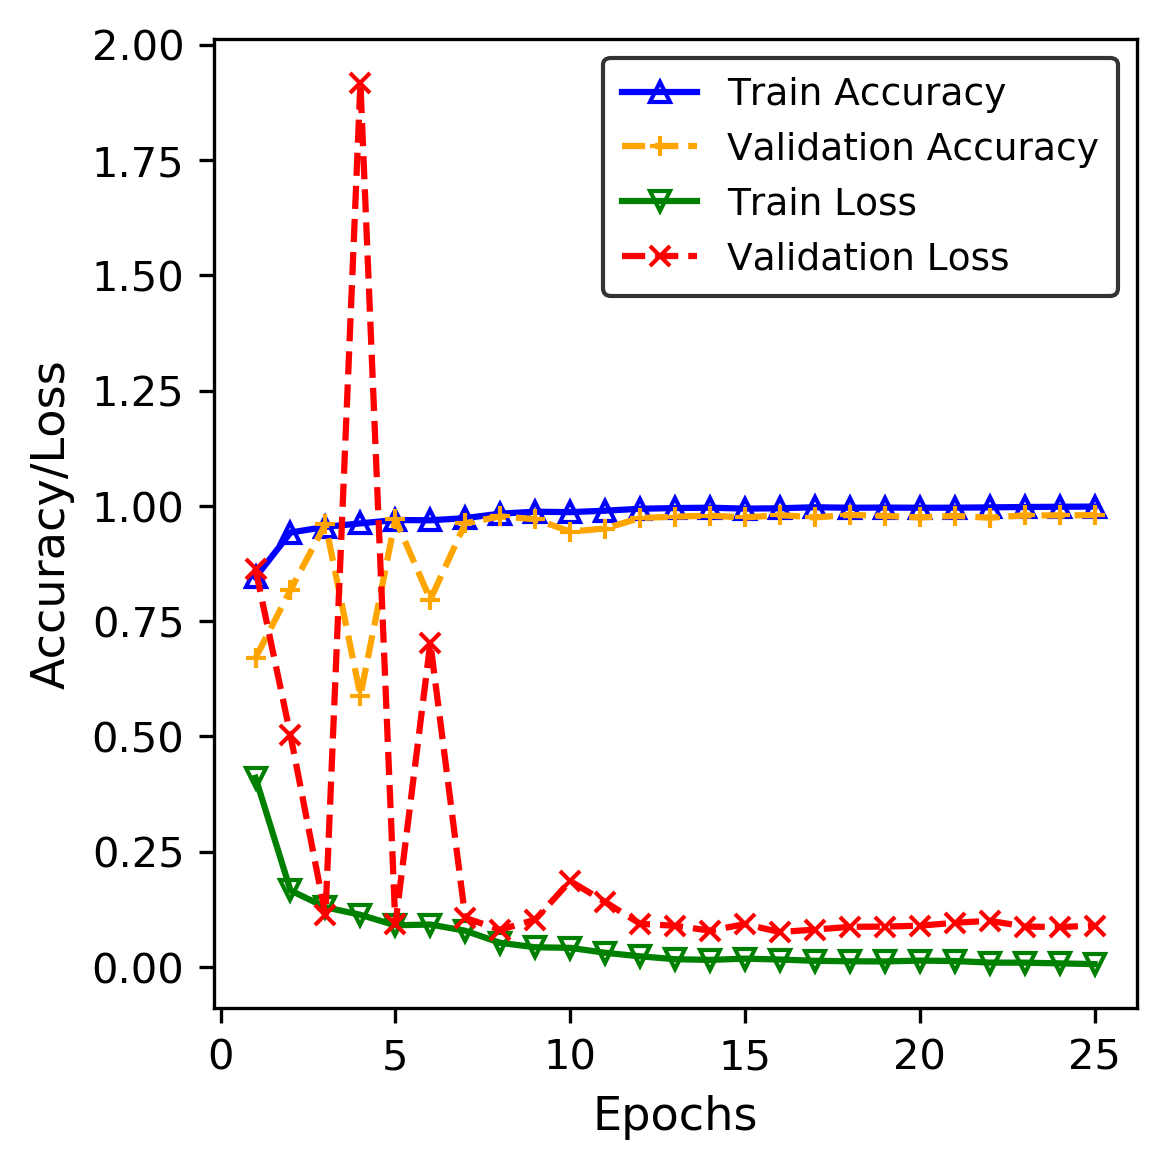

In [28]:
#PRINTS BOTH ACCURACY AND LOSS IN ONE GRAPH

N = epochs
plt.style.use("default")
plt.figure(figsize=(4,4), dpi=300)
plt.plot(np.arange(1, N+1), history.history["acc"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), history.history["val_acc"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")
plt.plot(np.arange(1, N+1), history.history["loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Loss")

plt.xlabel("Epochs", fontsize=3.7*3, color='black')
plt.ylabel("Accuracy/Loss", fontsize=3.7*3, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()
plt.savefig("figures/3-convergence.png")

In [9]:
#EVALUATION FOR THE FUSED-DENSENET-TINY

#evaluate accuracy
y_pred = model.predict_generator(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,y_pred.argmax(axis=-1))
print('The accuracy of the Fused DenseNet-Tiny model is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test,y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Fused DenseNet-Tiny model is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test,y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Fused DenseNet-Tiny model is: ', msle)

The accuracy of the Fused DenseNet-Tiny model is:  0.979902227050516
The Mean Squared Error of the Fused DenseNet-Tiny model is:  0.0755024443237371
The Mean Squared Log Error of the Fused DenseNet-Tiny model is:  0.022901451737836698


              precision    recall  f1-score   support

      Normal     0.9696    0.9755    0.9726       654
    COVID-19     1.0000    0.9883    0.9941       256
   Pneumonia     0.9817    0.9807    0.9812       931

    accuracy                         0.9799      1841
   macro avg     0.9838    0.9815    0.9826      1841
weighted avg     0.9800    0.9799    0.9799      1841

Confusion matrix, without normalization
[[638   0  16]
 [  2 253   1]
 [ 18   0 913]]


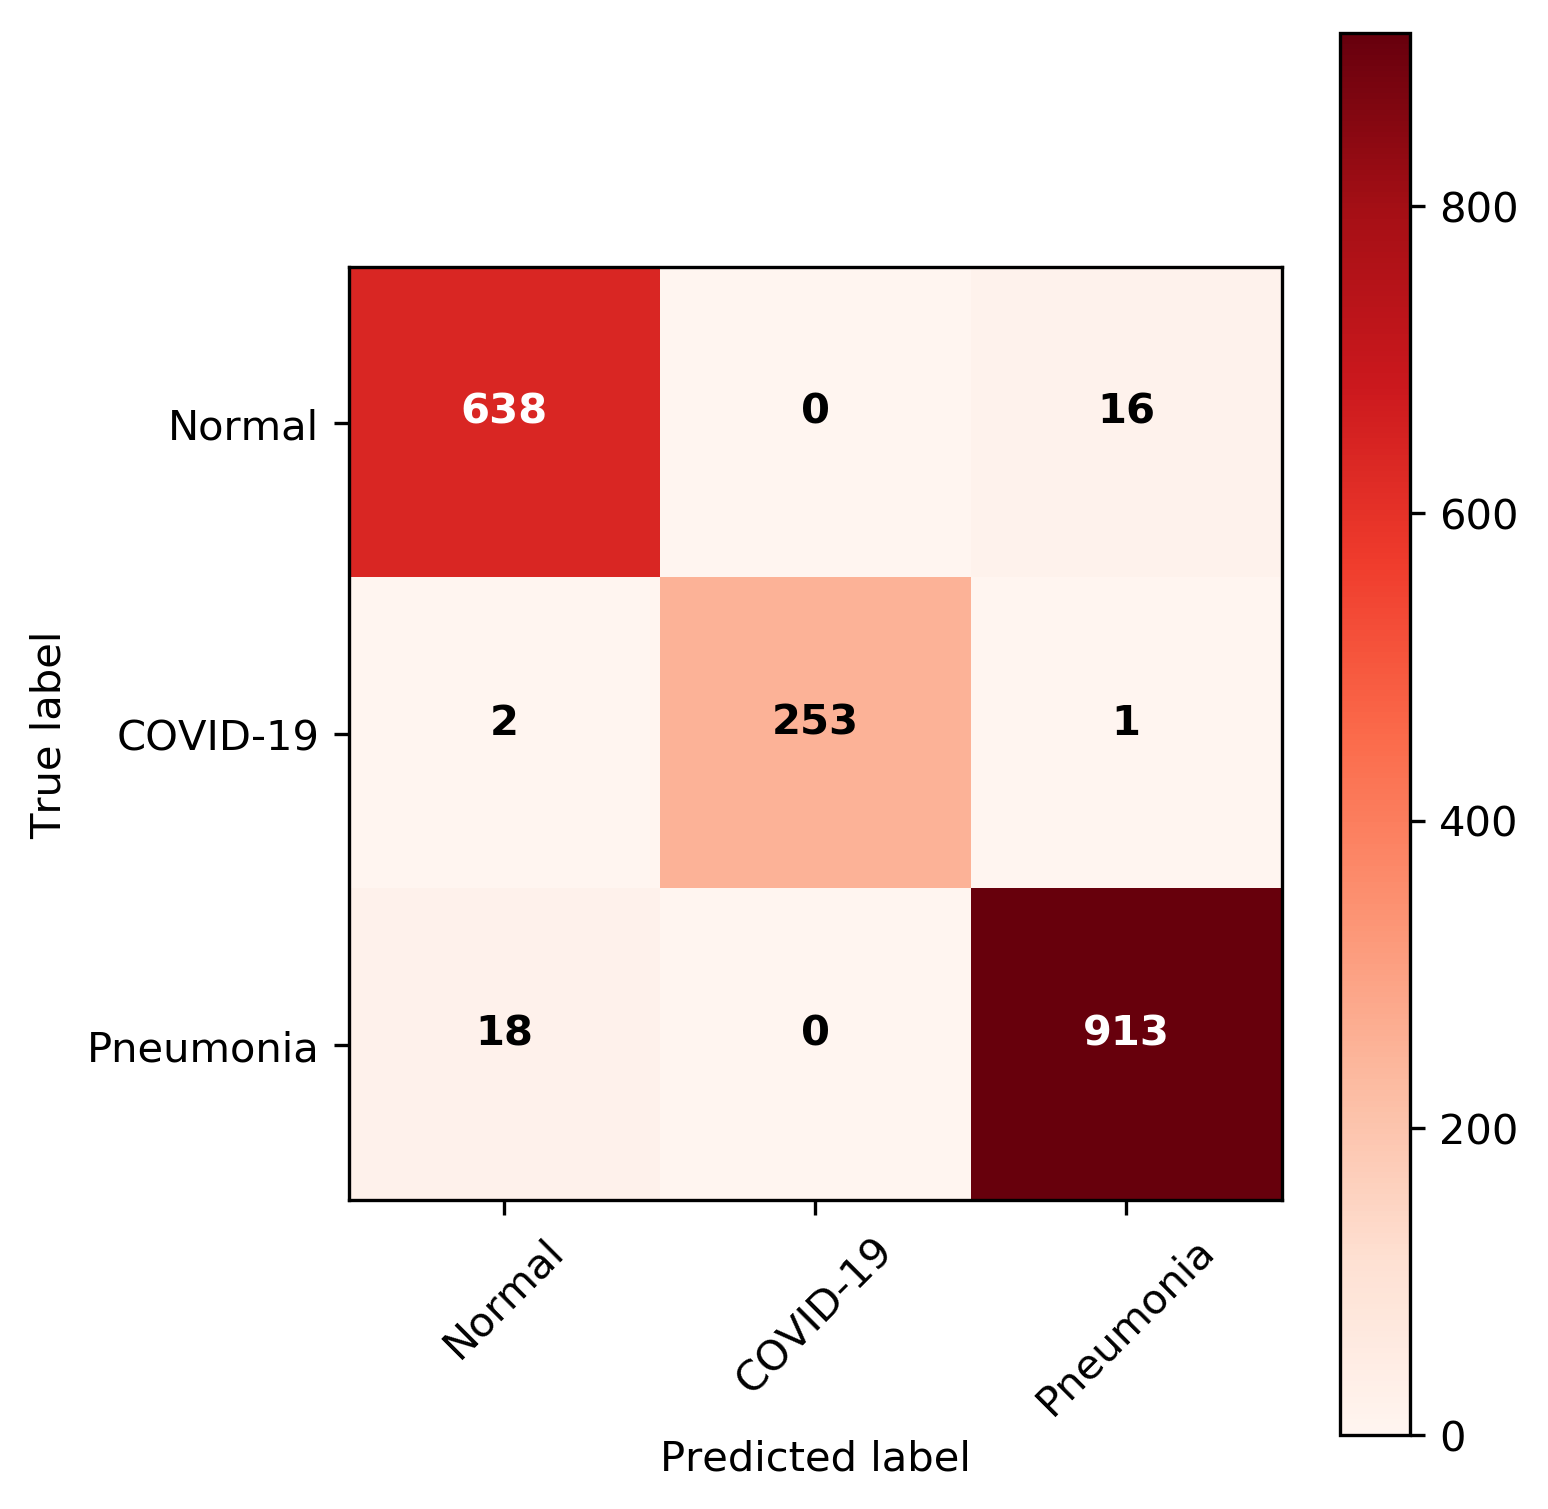

In [22]:
# CONFUSION MATRIX

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], weight='bold',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['Normal', 'COVID-19', 'Pneumonia']
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25,5.25), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.tight_layout()
plt.savefig("figures/confusion_matrix.png", dpi=600)
plt.show()

              precision    recall  f1-score   support

      Normal     0.9696    0.9755    0.9726       654
    COVID-19     1.0000    0.9883    0.9941       256
   Pneumonia     0.9817    0.9807    0.9812       931

    accuracy                         0.9799      1841
   macro avg     0.9838    0.9815    0.9826      1841
weighted avg     0.9800    0.9799    0.9799      1841

Normalized confusion matrix
[[0.9755 0.     0.0245]
 [0.0078 0.9883 0.0039]
 [0.0193 0.     0.9807]]


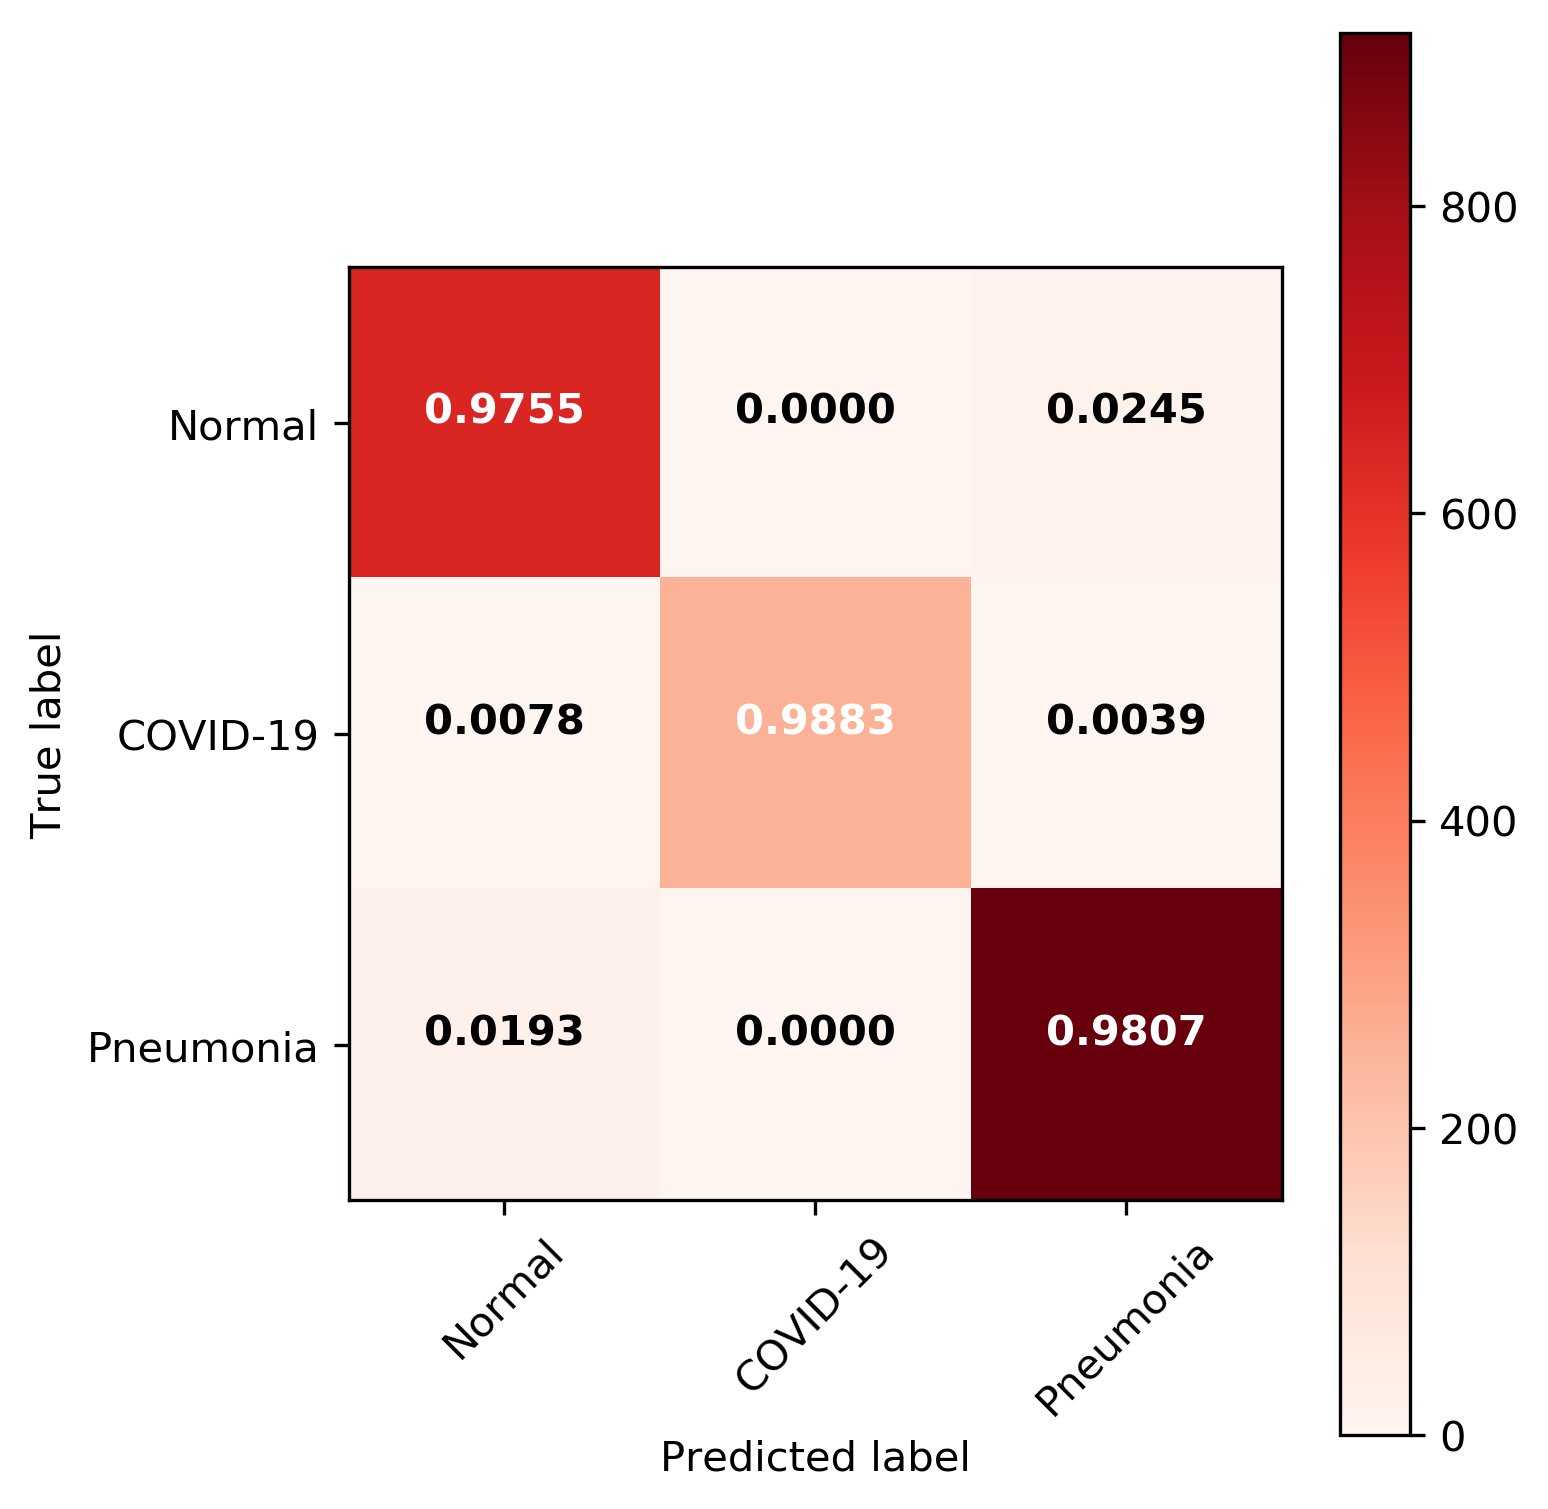

In [23]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.4f'), weight='bold',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['Normal', 'COVID-19', 'Pneumonia']
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25,5.25), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.tight_layout()
plt.savefig("figures/confusion_matrix-normalized.png", dpi=600)
plt.show()

<Figure size 2400x2400 with 0 Axes>

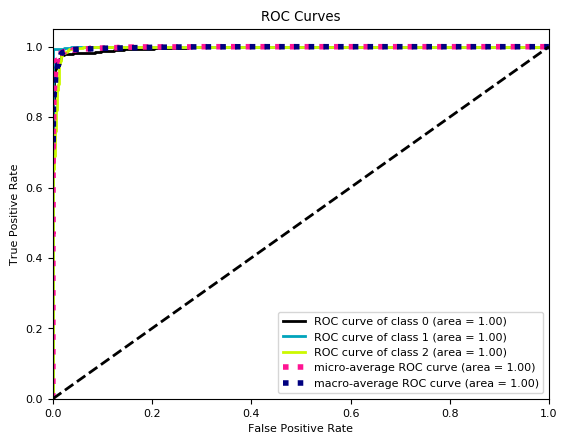

In [12]:
#PRINT THE ROC CURVE

plt.figure(figsize=(8,8), dpi=300)
plt.rcParams.update({'font.size': 8})
y_probas = model.predict(validation_generator)
scikitplot.metrics.plot_roc(Y_test, y_pred)
plt.savefig("figures/ROC_curve.png", dpi=600)
plt.show()

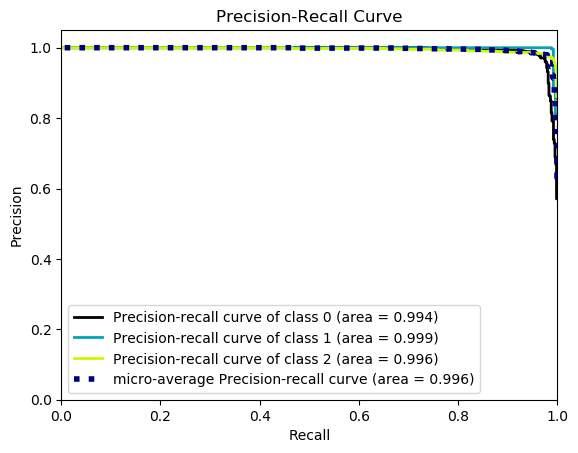

<Figure size 6000x6000 with 0 Axes>

In [13]:
#PRINT THE P-R CURVE

plt.rcParams.update({'font.size': 10})
y_probas = model.predict(validation_generator)
scikitplot.metrics.plot_precision_recall(Y_test, y_pred)
plt.savefig("figures/PR_curve.png", dpi=600)
plt.figure(figsize=(20, 20), dpi=300) 
plt.show()

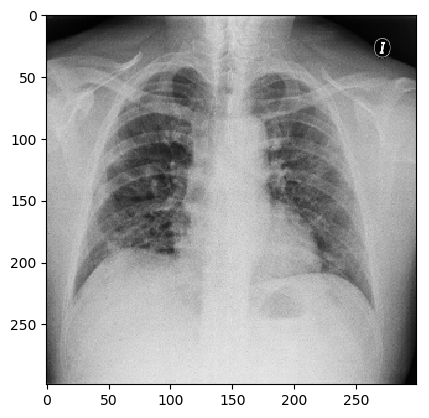

In [15]:
#TEST THE GRAD-CAM. LOAD ANY IMAGE FROM THE TEST FOLDER!

img_path = 'test/1.jpg'

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(img_width, img_height))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [16]:
preds = model.predict(x)
preds

array([[4.9146e-05, 9.9987e-01, 7.9633e-05]], dtype=float32)

In [17]:
result = np.argmax(preds[0])
result

1

In [18]:
#TAKE THE FEATURE IMPORTANCES FROM THE LAST CONV LAYER

grad_output = model.output[:, result]
last_conv_layer = model.get_layer('add_1')

grads = K.gradients(grad_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

#RANGE OF 224 IS BASED ON THE MAXIMUM FILTERS

for i in range(224):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

c:\users\jm\anaconda3\envs\gastro_cnn\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


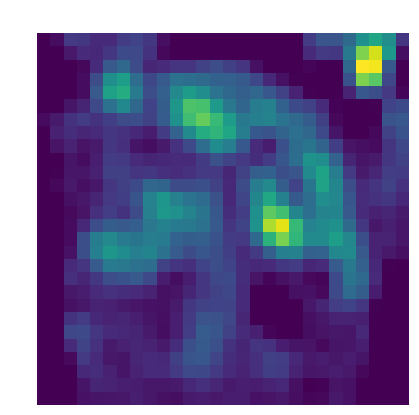

In [19]:
#PRODUCE THE GRAD-CAM HEATMAP

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.grid = False
plt.axis('off')
plt.savefig('grad-cam/sample.jpg', dpi=300, papertype='a4', bbox_inches=None,  pad_inches=0.0, facecolor=None)
plt.tight_layout()

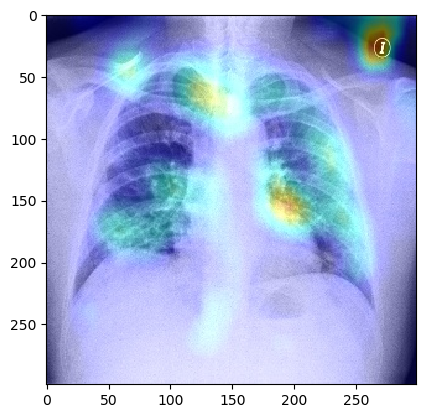

In [20]:
#PRINT THE OVERLAY

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(200 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

save_img_path = 'grad-cam/ample.jpg'

cv2.imwrite(save_img_path, superimposed_img)

img1 = image.load_img(save_img_path)
plt.imshow(img1);